# ANN for classification, exercise project 2 - Personality

## Dependancies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

To summarize:<br>
<b>'data.csv'</b> is the original dataset from kaggle.
<ul>
<li>I first analyzed the dataset in the file <b>'data_calc_code.ipynb'</b>, then saved the results to <b>'dataSynthClean.csv'</b>.</li>
<li>Then I analyzed the new dataset in the file<b> 'dataSynthClean_calc_code.ipynb'</b>, then saved the results to <b>'dataSynthCleanCapped.csv'</b>.</li>
<li>Lastly I analyzed the latest dataset in the file<b> 'dataSynthCleanCapped_calc_code.ipynb'</b>.</li>
</ul>

Now we are left with a heavily modified dataset.

In [4]:
df = pd.read_csv("data/dataSynthCleanCapped.csv")

In [5]:
df.head()

,Unnamed: 0,Age,isMale,Education,Extraversion Score,Sensing Score,Thinking Score,Judging Score,Personality,LikesSport
0,1,27.0,0,0,5.85392,6.160195,0.80552,4.221421,ESFP,1
1,2,21.0,0,0,7.08615,3.388433,2.66188,5.127320,ENFP,0
2,3,28.0,1,0,2.01892,4.823624,7.30625,5.986550,INTP,0
3,5,25.0,1,0,7.66292,5.758030,1.97014,4.563907,ENFP,0
4,6,26.0,0,1,2.73185,5.898910,3.64832,5.800525,INFP,0


In [6]:
df = df.drop("Unnamed: 0", axis=1)

## Creating the classification model

In [7]:
# everything else except the target variable
X = df.drop("Personality", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['Personality']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
3,Extraversion Score,694901.93
5,Thinking Score,613235.65
6,Judging Score,111758.65
2,Education,103233.35
4,Sensing Score,80491.84
0,Age,28302.97
7,LikesSport,14530.74
1,isMale,7767.17


In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [10]:
categories = list(np.unique(df['Personality']))
print(categories)

['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP']


In [17]:
# pip install keras-tuner
import keras_tuner

def build_model(hp):
    # iniatlize sequential test neural network
    model = keras.Sequential()

    # first layer, batch normalization + input shape, same as in typical neural network
    model.add(layers.BatchNormalization(input_shape=(len(X.columns),)),)
    
    # add the first actual layer including the regularizer
    model.add(
        layers.Dense(
            # Tune number of units separately.
            units=hp.Int(f"units_0", min_value=4, max_value=32, step=4),
            activation=hp.Choice("activation", ["relu"]),
            kernel_regularizer=keras.regularizers.l1(hp.Float("l1", min_value=0.1, max_value=0.2, sampling="log"))
        )
    )
        
    # automate a dropout layer
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(
            hp.Float("rate", min_value=0.1, max_value=0.4, step=0.1)
            ))

    # try additional layers, 1 or 2 extra layers
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i + 1}", min_value=8, max_value=64, step=4),
                activation=hp.Choice("activation", ["relu"]),
            )
        )

    # output layer, only one node since this is regression
    model.add(layers.Dense(len(categories), activation="softmax"))

    # automate learning rate tests
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    # compile the test neural network
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy', metrics=['accuracy']
    )

    return model


# build the model + use RandomSearch to actually search the best options for our neural network
build_model(keras_tuner.HyperParameters())

# use val_loss as the objective, because regression tasks do not have accuracy
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=8,
    executions_per_trial=2,
    overwrite=True,
    directory="optimizations3",
    project_name="classification1test",
)

# start searching
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 8 Complete [00h 19m 01s]
val_accuracy: 0.8410991132259369

Best val_accuracy So Far: 0.8579952120780945
Total elapsed time: 02h 02m 30s


In [18]:
# print out the result and suggestions
tuner.results_summary()

Results summary
Results in optimizations3\classification1test
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 5 summary
Hyperparameters:
units_0: 24
activation: relu
l1: 0.13261464410840956
dropout: False
num_layers: 2
units_1: 32
lr: 0.0009083541784678265
rate: 0.30000000000000004
units_2: 60
Score: 0.8579952120780945

Trial 2 summary
Hyperparameters:
units_0: 12
activation: relu
l1: 0.1919017180972998
dropout: False
num_layers: 2
units_1: 32
lr: 0.0007663853009890942
rate: 0.1
units_2: 60
Score: 0.8556273579597473

Trial 6 summary
Hyperparameters:
units_0: 4
activation: relu
l1: 0.18828815630880122
dropout: False
num_layers: 2
units_1: 40
lr: 0.0004272970012783842
rate: 0.1
units_2: 44
Score: 0.8425639867782593

Trial 7 summary
Hyperparameters:
units_0: 20
activation: relu
l1: 0.13796787195909807
dropout: True
num_layers: 1
units_1: 32
lr: 0.00028007529232923885
rate: 0.4
units_2: 40
Score: 0.8410991132259369

Trial 3 summary
Hyperparameters:
units_0: 4


In [19]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           976 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 3,988 (15.58 KB)

 Non-trainable params: 16 (64.00 B)

### First Model

First, let's try the keras tuner suggestion:

In [ ]:
# let's try with a simple neural network
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(24, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(60, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

optimal_lr = 0.0009083541784678265

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 60)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           976 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 3,988 (15.58 KB)

 Non-trainable params: 16 (64.00 B)

In [ ]:
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_val, y_val))

NameError: name 'model' is not defined

<Axes: >

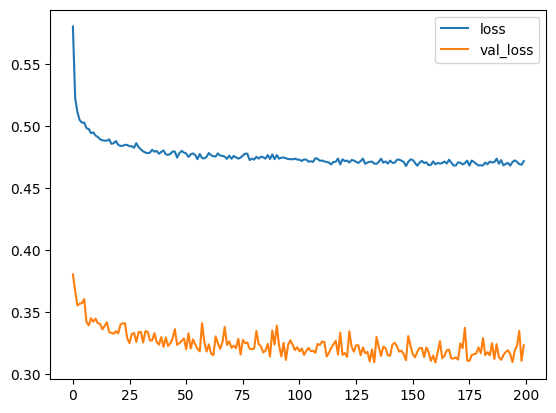

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

Pretty good, the validation loss is below loss, so no overfitting. It also seems that the model is learning pretty fast and stabilizing early. But the gap between these two is very big, we might need some fine tuning with regularizers. Overall, it generalizes very well and does not seem to have any big spikes.

<Axes: >

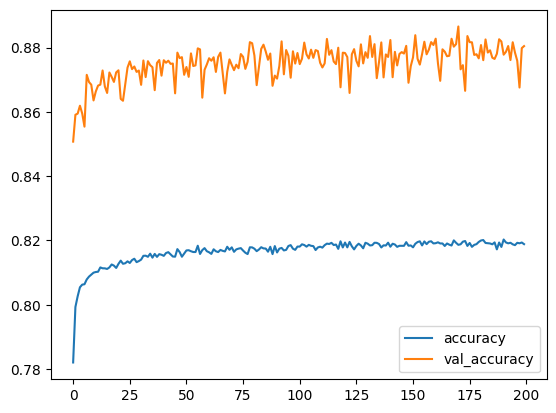

In [ ]:
loss_df[['accuracy', 'val_accuracy']].plot()

Same here, it generalizes very well and the accuracy overall is also very good. It might still need some fine tuning.

In [ ]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.3178660273551941, 0.8827129602432251]

Train data evaluation:
[0.3204784691333771, 0.8809598088264465]


The numbers are pretty similiar, very good.

In [ ]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

1558/1558 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


<Axes: >

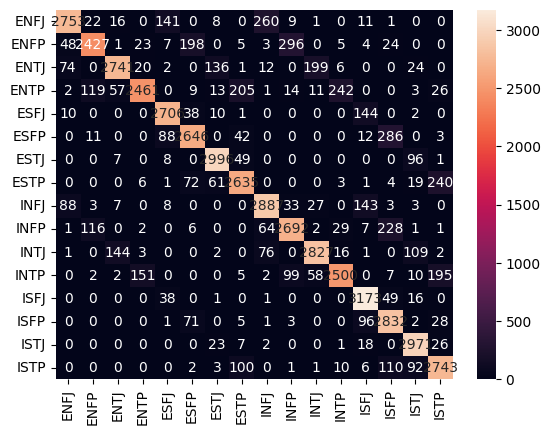

In [ ]:
 # confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

Weirdly enough, it seems that the model has issues to differentiate the Extravert and Introvert trait of the examples most often. It also wrongly guesses the Sensing and Intuition traits in some cases. We can also see, that there are a few wrong predictions when it comes to Judging and Perceiving. It seemingly is the most accurate when it comes to the Thinking and Feeling traits.<br>
According to the analyzations we did before, this is the order of importance:<br>
(from highest importance to lowest)
<ul>
<li>Thinking/Feeling</li>
<li>Extravert/Introvert</li>
<li>Sensing/Intuition</li>
<li>Judging/Perceiving</li>
</ul><br>
While the model seems to have a different order of accuracy:<br>
(from least amount of wrong guesses to most amount)
<ul>
<li>Thinking/Feeling</li>
<li>Judging/Perceiving</li>
<li>Sensing/Intuition</li>
<li>Extravert/Introvert</li>
</ul><br>
Extravert/Introvert is the most surprising here, because it's really consistently inconsistent.<br><br>
Otherwise, this is model proves to be very accurate.

In [ ]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89      3222
           1       0.90      0.80      0.85      3041
           2       0.92      0.85      0.89      3215
           3       0.92      0.78      0.84      3163
           4       0.90      0.93      0.92      2911
           5       0.87      0.86      0.86      3088
           6       0.92      0.95      0.93      3157
           7       0.86      0.87      0.86      3042
           8       0.87      0.90      0.89      3202
           9       0.86      0.85      0.86      3149
          10       0.90      0.89      0.90      3181
          11       0.89      0.82      0.86      3031
          12       0.88      0.97      0.92      3278
          13       0.80      0.93      0.86      3039
          14       0.89      0.97      0.93      3048
          15       0.84      0.89      0.87      3068

    accuracy                           0.88     49835
   macro avg       0.88   

Overall accuracy of 88.27%, very good.

In [ ]:
df.head()

,Age,isMale,Education,Extraversion Score,Sensing Score,Thinking Score,Judging Score,Personality,LikesSport
0,27.00,0,0,5.85,6.16,0.81,4.22,ESFP,1
1,21.00,0,0,7.09,3.39,2.66,5.13,ENFP,0
2,28.00,1,0,2.02,4.82,7.31,5.99,INTP,0
3,25.00,1,0,7.66,5.76,1.97,4.56,ENFP,0
4,26.00,0,1,2.73,5.90,3.65,5.80,INFP,0


In [ ]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'Age': 29, 
    'isMale': 1, 
    'Education': 1,  
    'Extraversion Score': 3.33, 
    'Sensing Score': 7.2, 
    'Thinking Score': 8.9,
    'Judging Score': 2.12,
    'LikesSport': 0, 
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

print(result)

# 0 cheapest, 3 most expensive
print("What personality type are you?")
print(f"Predicted Personality type: {result_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[2.9692496e-16 2.6292163e-15 2.4363815e-11 2.8439472e-06 2.4375620e-15
 1.8433204e-10 8.2552232e-09 4.2656917e-02 2.4271128e-16 4.7142797e-18
 5.1688920e-10 1.3793347e-03 1.3051138e-11 1.9008259e-06 9.5124946e-05
 9.5586377e-01]
What personality type are you?
Predicted Personality type: ISTP


This is a correct prediction!

In [ ]:
len(y_test)

49835

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Second Model

Let's try to add a regularizer.

In [22]:
# let's try with a simple neural network
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(32, activation="relu"),
        layers.Dense(60, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

optimal_lr = 0.0009083541784678265

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 60)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           976 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 3,988 (15.58 KB)

 Non-trainable params: 16 (64.00 B)

In [35]:
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.7919 - loss: 0.5916 - val_accuracy: 0.8614 - val_loss: 0.4141
Epoch 2/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.7921 - loss: 0.5893 - val_accuracy: 0.8573 - val_loss: 0.4152
Epoch 3/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.7914 - loss: 0.5916 - val_accuracy: 0.8536 - val_loss: 0.4257
Epoch 4/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.7918 - loss: 0.5910 - val_accuracy: 0.8589 - val_loss: 0.4181
Epoch 5/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.7934 - loss: 0.5873 - val_accuracy: 0.8576 - val_loss: 0.4288
Epoch 6/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.7926 - loss: 0.5887 - val_accuracy: 0.8642 - val_loss: 0.4185
Epoch 7/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.7920 - loss: 0.5939 - val_accuracy: 0.8532 - val_loss: 0.4301
Epoch 8/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - ac

<Axes: >

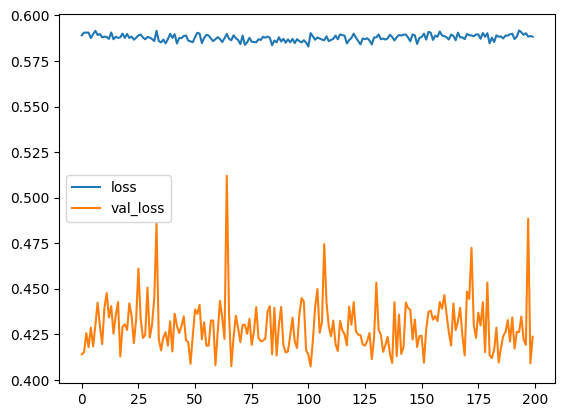

In [36]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

The big gap remains and we have gained some unwanted spikes. Also, it seems that the model isn't even learning at the beginning. Still, no overfitting.

<Axes: >

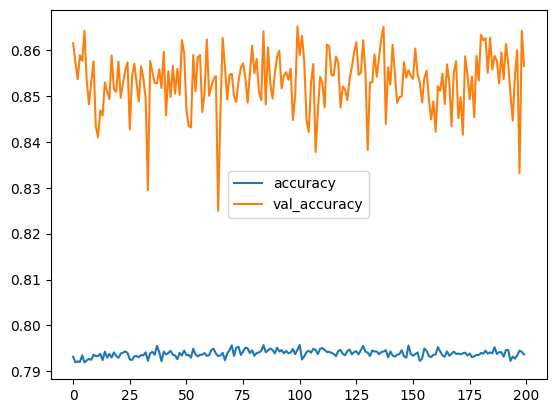

In [37]:
loss_df[['accuracy', 'val_accuracy']].plot()

Same here, unwanted spikes and no learning curve, the accuracy is also lower than the first model.

In [43]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.4225470721721649, 0.8566067814826965]

Train data evaluation:
[0.42382290959358215, 0.8556532859802246]


These numbers are very close together though, that's better than the first model.

In [44]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

1558/1558 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


<Axes: >

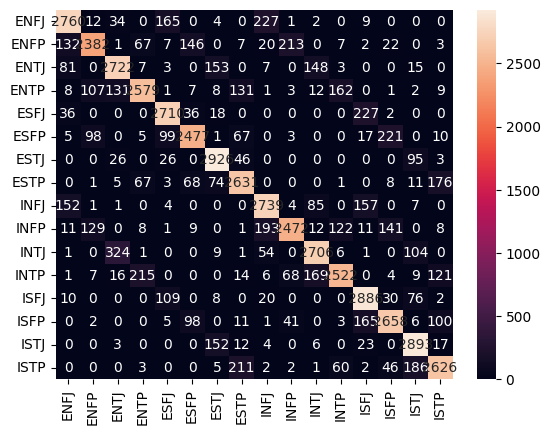

In [45]:
 # confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

Didn't change much.

In [46]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3214
           1       0.87      0.79      0.83      3009
           2       0.83      0.87      0.85      3139
           3       0.87      0.82      0.84      3162
           4       0.86      0.89      0.88      3029
           5       0.87      0.82      0.85      3003
           6       0.87      0.94      0.90      3122
           7       0.84      0.86      0.85      3045
           8       0.84      0.87      0.85      3150
           9       0.88      0.79      0.83      3118
          10       0.86      0.84      0.85      3207
          11       0.87      0.80      0.84      3152
          12       0.82      0.92      0.87      3141
          13       0.85      0.86      0.85      3090
          14       0.85      0.93      0.89      3110
          15       0.85      0.84      0.84      3144

    accuracy                           0.86     49835
   macro avg       0.86   

Overall accuracy of around 86%, not bad, but a bit worse than before.

In [47]:
df.head()

,Age,isMale,Education,Extraversion Score,Sensing Score,Thinking Score,Judging Score,Personality,LikesSport
0,27.00,0,0,5.85,6.16,0.81,4.22,ESFP,1
1,21.00,0,0,7.09,3.39,2.66,5.13,ENFP,0
2,28.00,1,0,2.02,4.82,7.31,5.99,INTP,0
3,25.00,1,0,7.66,5.76,1.97,4.56,ENFP,0
4,26.00,0,1,2.73,5.90,3.65,5.80,INFP,0


In [48]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'Age': 29, 
    'isMale': 1, 
    'Education': 1,  
    'Extraversion Score': 3.33, 
    'Sensing Score': 7.2, 
    'Thinking Score': 8.9,
    'Judging Score': 2.12,
    'LikesSport': 0, 
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

print(result)

# 0 cheapest, 3 most expensive
print("What personality type are you?")
print(f"Predicted Personality type: {result_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[6.04299576e-23 4.25390797e-21 1.15206755e-09 3.77882134e-05
 1.17208798e-10 4.10303097e-10 1.06806183e-04 1.35607481e-01
 1.04233545e-10 2.06993800e-09 3.20575779e-08 6.55515061e-04
 1.33260002e-07 5.04181917e-05 8.76655860e-04 8.62665176e-01]
What personality type are you?
Predicted Personality type: ISTP


Guessed right!

In [49]:
len(y_test)

49835

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Third Model

Let's try with some dropout layers.

In [12]:
# let's try with a simple neural network
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(24, activation="relu", ),
        layers.Dropout(0.1),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(60, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

optimal_lr = 0.0009083541784678265

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           976 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 3,988 (15.58 KB)

 Non-trainable params: 16 (64.00 B)

In [13]:
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.6879 - loss: 0.8844 - val_accuracy: 0.8521 - val_loss: 0.3832
Epoch 2/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - accuracy: 0.7837 - loss: 0.5912 - val_accuracy: 0.8592 - val_loss: 0.3586
Epoch 3/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - accuracy: 0.7890 - loss: 0.5614 - val_accuracy: 0.8597 - val_loss: 0.3655
Epoch 4/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7915 - loss: 0.5536 - val_accuracy: 0.8529 - val_loss: 0.3702
Epoch 5/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7953 - loss: 0.5404 - val_accuracy: 0.8546 - val_loss: 0.3671
Epoch 6/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7959 - loss: 0.5435 - val_accuracy: 0.8470 - val_loss: 0.3730
Epoch 7/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7948 - loss: 0.5417 - val_accuracy: 0.8551 - val_loss: 0.3625
Epoch 8/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - ac

<Axes: >

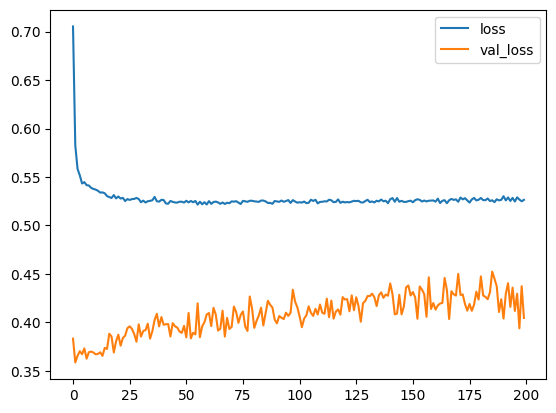

In [14]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

The model now seems to learn more and stagnates more than before. Though it still spikes, it is not as bad as the second model.

<Axes: >

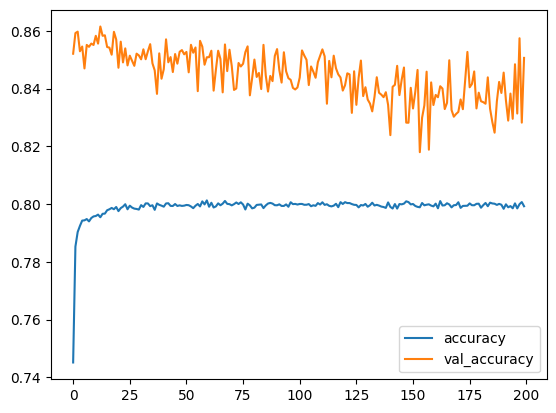

In [15]:
loss_df[['accuracy', 'val_accuracy']].plot()

Same here, good overall learning ability, and an actually close gap, though the overall accuracy is lower than the first model.

In [16]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.39965391159057617, 0.8537975549697876]

Train data evaluation:
[0.40002793073654175, 0.8521767258644104]


Also very good numbers here.

In [17]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

1558/1558 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


<Axes: >

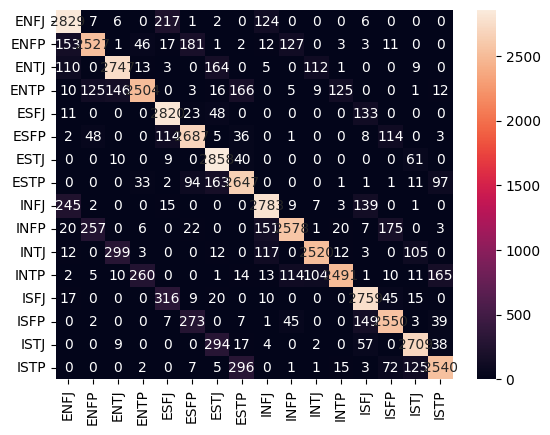

In [18]:
 # confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

Not much changed here.

In [19]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3192
           1       0.85      0.82      0.83      3084
           2       0.85      0.87      0.86      3164
           3       0.87      0.80      0.84      3122
           4       0.80      0.93      0.86      3035
           5       0.81      0.89      0.85      3018
           6       0.80      0.96      0.87      2978
           7       0.82      0.87      0.84      3050
           8       0.86      0.87      0.87      3204
           9       0.90      0.80      0.84      3240
          10       0.91      0.82      0.86      3083
          11       0.93      0.78      0.85      3201
          12       0.84      0.86      0.85      3191
          13       0.86      0.83      0.84      3076
          14       0.89      0.87      0.88      3130
          15       0.88      0.83      0.85      3067

    accuracy                           0.85     49835
   macro avg       0.86   

Overall good accuracy.

In [20]:
df.head()

,Age,isMale,Education,Extraversion Score,Sensing Score,Thinking Score,Judging Score,Personality,LikesSport
0,27.00,0,0,5.85,6.16,0.81,4.22,ESFP,1
1,21.00,0,0,7.09,3.39,2.66,5.13,ENFP,0
2,28.00,1,0,2.02,4.82,7.31,5.99,INTP,0
3,25.00,1,0,7.66,5.76,1.97,4.56,ENFP,0
4,26.00,0,1,2.73,5.90,3.65,5.80,INFP,0


In [21]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'Age': 29, 
    'isMale': 1, 
    'Education': 1,  
    'Extraversion Score': 3.33, 
    'Sensing Score': 7.2, 
    'Thinking Score': 8.9,
    'Judging Score': 2.12,
    'LikesSport': 0, 
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

print(result)

# 0 cheapest, 3 most expensive
print("What personality type are you?")
print(f"Predicted Personality type: {result_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[8.4121404e-11 1.8875566e-06 1.1993801e-07 3.6020633e-03 9.9417354e-09
 6.3691339e-05 2.2714352e-05 1.3909601e-01 2.5068167e-10 8.7657118e-06
 2.6593483e-07 1.3851307e-02 1.2138490e-07 1.8023253e-04 1.8136502e-04
 8.4299153e-01]
What personality type are you?
Predicted Personality type: ISTP


In [22]:
len(y_test)

49835

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Fourth Model

Now let's add some regularizers to that.

In [76]:
# let's try with a simple neural network
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1) ),
        layers.Dropout(0.1),
        layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),
        layers.Dropout(0.1),
        layers.Dense(60, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),
        layers.Dense(len(categories), activation="softmax")
    ]
)

optimal_lr = 0.0009083541784678265

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 60)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           976 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 3,988 (15.58 KB)

 Non-trainable params: 16 (64.00 B)

In [77]:
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.1638 - loss: 2.8454 - val_accuracy: 0.4246 - val_loss: 1.5252
Epoch 2/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.3990 - loss: 1.5518 - val_accuracy: 0.4316 - val_loss: 1.2874
Epoch 3/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.4037 - loss: 1.4227 - val_accuracy: 0.4403 - val_loss: 1.2408
Epoch 4/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.4045 - loss: 1.3852 - val_accuracy: 0.4272 - val_loss: 1.2373
Epoch 5/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.4063 - loss: 1.3624 - val_accuracy: 0.4396 - val_loss: 1.1760
Epoch 6/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.4059 - loss: 1.3480 - val_accuracy: 0.4405 - val_loss: 1.1975
Epoch 7/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.4062 - loss: 1.3363 - val_accuracy: 0.4350 - val_loss: 1.1976
Epoch 8/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - ac

<Axes: >

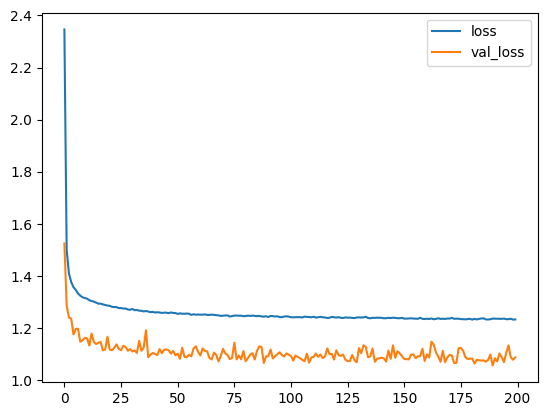

In [78]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

It now seems to learn quite well, and the gap is even closer, though the loss is higher than any model before.

<Axes: >

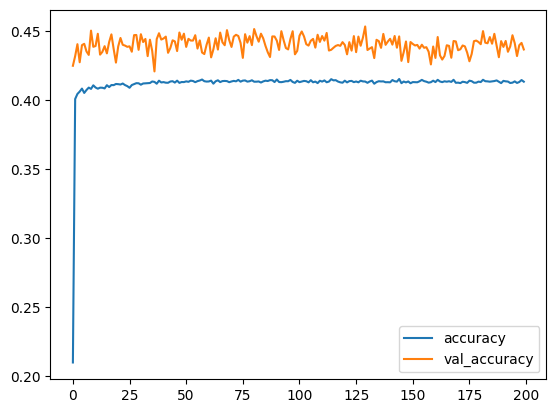

In [79]:
loss_df[['accuracy', 'val_accuracy']].plot()

Same here, good gap between those two, but a very low overall accuracy.

In [80]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[1.094629168510437, 0.43473461270332336]

Train data evaluation:
[1.0944921970367432, 0.43613797426223755]


Pretty similiar, again.

In [81]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

1558/1558 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


<Axes: >

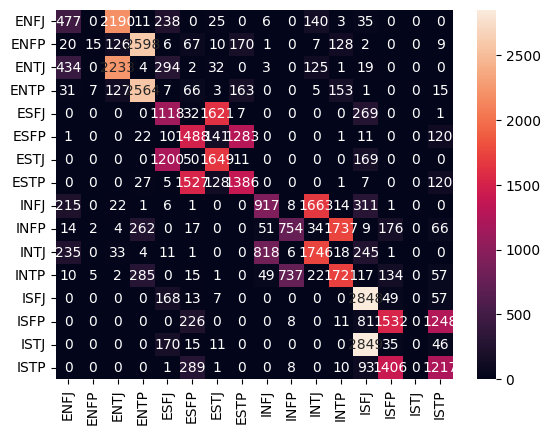

In [82]:
 # confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

Oh, here we have a big problem, it didn't guess a single ISTJ right. There were also a high amount of wrong guesses, this is not good.

In [83]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.33      0.15      0.21      3125
           1       0.52      0.00      0.01      3159
           2       0.47      0.71      0.57      3147
           3       0.44      0.82      0.57      3142
           4       0.35      0.37      0.36      3048
           5       0.39      0.48      0.43      3077
           6       0.45      0.54      0.49      3079
           7       0.46      0.43      0.45      3201
           8       0.50      0.29      0.37      3159
           9       0.50      0.24      0.32      3126
          10       0.47      0.56      0.51      3118
          11       0.45      0.56      0.50      3055
          12       0.41      0.91      0.56      3142
          13       0.46      0.49      0.48      3106
          14       0.00      0.00      0.00      3126
          15       0.41      0.40      0.41      3025

    accuracy                           0.43     49835
   macro avg       0.41   

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicte

Yeah, 43% accuracy, this model is not accurate.

In [84]:
df.head()

,Age,isMale,Education,Extraversion Score,Sensing Score,Thinking Score,Judging Score,Personality,LikesSport
0,27.00,0,0,5.85,6.16,0.81,4.22,ESFP,1
1,21.00,0,0,7.09,3.39,2.66,5.13,ENFP,0
2,28.00,1,0,2.02,4.82,7.31,5.99,INTP,0
3,25.00,1,0,7.66,5.76,1.97,4.56,ENFP,0
4,26.00,0,1,2.73,5.90,3.65,5.80,INFP,0


In [85]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'Age': 29, 
    'isMale': 1, 
    'Education': 1,  
    'Extraversion Score': 3.33, 
    'Sensing Score': 7.2, 
    'Thinking Score': 8.9,
    'Judging Score': 2.12,
    'LikesSport': 0, 
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

print(result)

# 0 cheapest, 3 most expensive
print("What personality type are you?")
print(f"Predicted Personality type: {result_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[1.9669028e-07 1.4312103e-03 1.7486857e-07 1.3981825e-03 7.8449091e-07
 1.5739217e-02 9.6697158e-07 1.3943097e-02 4.9542218e-06 2.7288064e-02
 3.7662317e-06 2.7931493e-02 6.8175250e-05 4.5185801e-01 6.3995438e-05
 4.6026769e-01]
What personality type are you?
Predicted Personality type: ISTP


Still, a right prediction.

In [86]:
len(y_test)

49835

In [87]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Fifth Model

In [24]:
# let's try with a simple neural network
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1) ),
        layers.Dense(32, activation="relu"),
        layers.Dense(60, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

optimal_lr = 0.0009083541784678265

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 60)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           976 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 3,988 (15.58 KB)

 Non-trainable params: 16 (64.00 B)

In [25]:
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.7445 - loss: 0.8686 - val_accuracy: 0.8525 - val_loss: 0.4065
Epoch 2/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.7952 - loss: 0.5562 - val_accuracy: 0.8451 - val_loss: 0.4111
Epoch 3/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.7945 - loss: 0.5537 - val_accuracy: 0.8569 - val_loss: 0.3970
Epoch 4/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.7966 - loss: 0.5439 - val_accuracy: 0.8520 - val_loss: 0.3886
Epoch 5/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.7974 - loss: 0.5418 - val_accuracy: 0.8542 - val_loss: 0.3927
Epoch 6/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.7978 - loss: 0.5399 - val_accuracy: 0.8571 - val_loss: 0.3890
Epoch 7/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.7982 - loss: 0.5367 - val_accuracy: 0.8569 - val_loss: 0.3745
Epoch 8/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - ac

<Axes: >

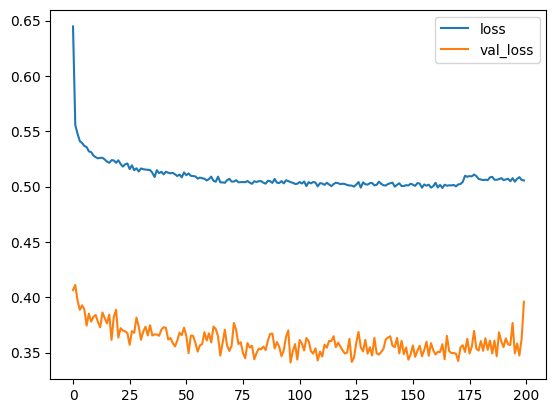

In [26]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

It now seems to learn quite well, and the gap is even closer, though the loss is higher than any model before.

<Axes: >

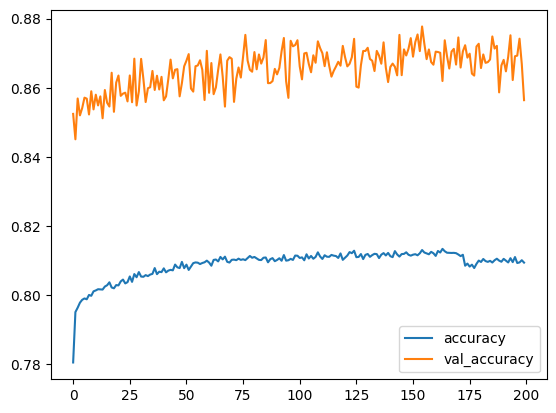

In [27]:
loss_df[['accuracy', 'val_accuracy']].plot()

Same here, good gap between those two, but a very low overall accuracy.

In [28]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.3953286409378052, 0.856687068939209]

Train data evaluation:
[0.3944454491138458, 0.8571482300758362]


Pretty similiar, again.

In [29]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

1558/1558 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


<Axes: >

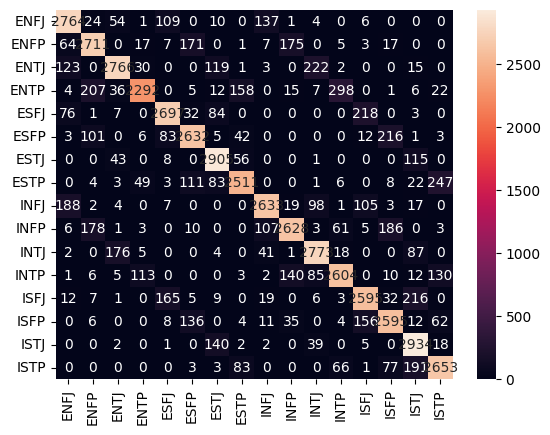

In [30]:
 # confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

Oh, here we have a big problem, it didn't guess a single ISTJ right. There were also a high amount of wrong guesses, this is not good.

In [31]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3110
           1       0.83      0.85      0.84      3178
           2       0.89      0.84      0.87      3281
           3       0.91      0.75      0.82      3063
           4       0.87      0.86      0.87      3118
           5       0.85      0.85      0.85      3104
           6       0.86      0.93      0.89      3128
           7       0.88      0.82      0.85      3048
           8       0.89      0.86      0.87      3077
           9       0.87      0.82      0.85      3191
          10       0.86      0.89      0.87      3107
          11       0.85      0.84      0.84      3111
          12       0.84      0.85      0.84      3070
          13       0.83      0.86      0.84      3029
          14       0.81      0.93      0.87      3143
          15       0.85      0.86      0.85      3077

    accuracy                           0.86     49835
   macro avg       0.86   

Yeah, 43% accuracy, this model is not accurate.

In [32]:
df.head()

,Age,isMale,Education,Extraversion Score,Sensing Score,Thinking Score,Judging Score,Personality,LikesSport
0,27.00,0,0,5.85,6.16,0.81,4.22,ESFP,1
1,21.00,0,0,7.09,3.39,2.66,5.13,ENFP,0
2,28.00,1,0,2.02,4.82,7.31,5.99,INTP,0
3,25.00,1,0,7.66,5.76,1.97,4.56,ENFP,0
4,26.00,0,1,2.73,5.90,3.65,5.80,INFP,0


In [33]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'Age': 29, 
    'isMale': 1, 
    'Education': 1,  
    'Extraversion Score': 3.33, 
    'Sensing Score': 7.2, 
    'Thinking Score': 8.9,
    'Judging Score': 2.12,
    'LikesSport': 0, 
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

print(result)

# 0 cheapest, 3 most expensive
print("What personality type are you?")
print(f"Predicted Personality type: {result_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[2.6370133e-19 5.8518831e-13 6.8363075e-22 3.0465353e-05 2.3173102e-15
 1.0659703e-07 3.7469975e-17 1.9826818e-02 2.0813981e-20 7.3418754e-10
 1.8144670e-18 1.5563221e-03 9.1630711e-16 1.5280460e-04 4.0279297e-14
 9.7843355e-01]
What personality type are you?
Predicted Personality type: ISTP


Still, a right prediction.

In [34]:
len(y_test)

49835

In [35]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Sixth Model

In [36]:
# let's try with a simple neural network
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1) ),
        layers.Dropout(0.1),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(60, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

optimal_lr = 0.0009083541784678265

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 60)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           976 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 3,988 (15.58 KB)

 Non-trainable params: 16 (64.00 B)

In [37]:
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6953 - loss: 1.0084 - val_accuracy: 0.8513 - val_loss: 0.4249
Epoch 2/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7795 - loss: 0.6320 - val_accuracy: 0.8596 - val_loss: 0.3959
Epoch 3/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7839 - loss: 0.6096 - val_accuracy: 0.8508 - val_loss: 0.4122
Epoch 4/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7836 - loss: 0.6068 - val_accuracy: 0.8556 - val_loss: 0.4078
Epoch 5/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7854 - loss: 0.6030 - val_accuracy: 0.8549 - val_loss: 0.4062
Epoch 6/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7841 - loss: 0.6041 - val_accuracy: 0.8522 - val_loss: 0.4155
Epoch 7/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7849 - loss: 0.5996 - val_accuracy: 0.8502 - val_loss: 0.4034
Epoch 8/200
12459/12459 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - ac

<Axes: >

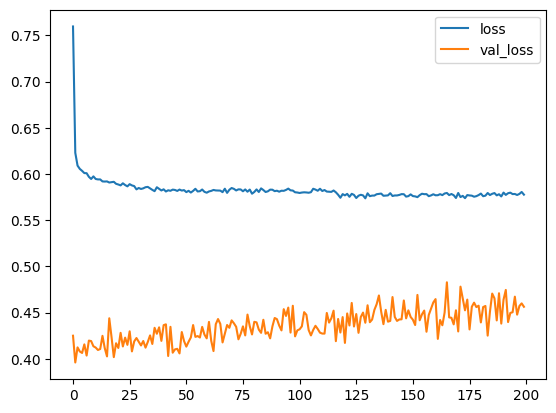

In [38]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

It now seems to learn quite well, and the gap is even closer, though the loss is higher than any model before.

<Axes: >

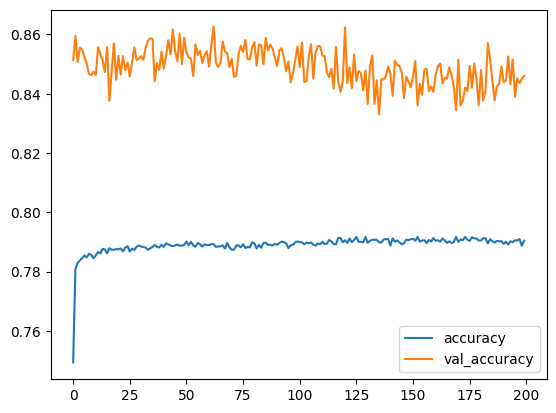

In [39]:
loss_df[['accuracy', 'val_accuracy']].plot()

Same here, good gap between those two, but a very low overall accuracy.

In [40]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.45553094148635864, 0.8456506729125977]

Train data evaluation:
[0.45724034309387207, 0.843375027179718]


Pretty similiar, again.

In [41]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

1558/1558 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


<Axes: >

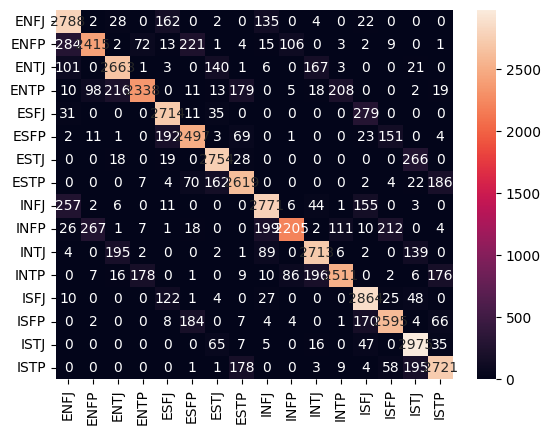

In [42]:
 # confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

Oh, here we have a big problem, it didn't guess a single ISTJ right. There were also a high amount of wrong guesses, this is not good.

In [43]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      3143
           1       0.86      0.77      0.81      3148
           2       0.85      0.86      0.85      3106
           3       0.90      0.75      0.82      3117
           4       0.84      0.88      0.86      3070
           5       0.83      0.85      0.84      2954
           6       0.87      0.89      0.88      3085
           7       0.84      0.85      0.85      3076
           8       0.85      0.85      0.85      3256
           9       0.91      0.72      0.81      3063
          10       0.86      0.86      0.86      3153
          11       0.88      0.79      0.83      3198
          12       0.80      0.92      0.86      3101
          13       0.85      0.85      0.85      3045
          14       0.81      0.94      0.87      3150
          15       0.85      0.86      0.85      3170

    accuracy                           0.85     49835
   macro avg       0.85   

Yeah, 43% accuracy, this model is not accurate.

In [44]:
df.head()

,Age,isMale,Education,Extraversion Score,Sensing Score,Thinking Score,Judging Score,Personality,LikesSport
0,27.00,0,0,5.85,6.16,0.81,4.22,ESFP,1
1,21.00,0,0,7.09,3.39,2.66,5.13,ENFP,0
2,28.00,1,0,2.02,4.82,7.31,5.99,INTP,0
3,25.00,1,0,7.66,5.76,1.97,4.56,ENFP,0
4,26.00,0,1,2.73,5.90,3.65,5.80,INFP,0


In [45]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'Age': 29, 
    'isMale': 1, 
    'Education': 1,  
    'Extraversion Score': 3.33, 
    'Sensing Score': 7.2, 
    'Thinking Score': 8.9,
    'Judging Score': 2.12,
    'LikesSport': 0, 
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

print(result)

# 0 cheapest, 3 most expensive
print("What personality type are you?")
print(f"Predicted Personality type: {result_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[4.7261583e-17 2.9698626e-06 9.3013315e-15 1.4446134e-03 1.3987682e-15
 3.3113003e-05 6.9672107e-12 3.2940559e-02 1.4324301e-16 8.7978646e-05
 7.0226519e-14 3.9446641e-02 3.0340444e-13 1.6206931e-03 4.0712021e-11
 9.2442352e-01]
What personality type are you?
Predicted Personality type: ISTP


Still, a right prediction.

In [46]:
len(y_test)

49835

In [47]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

## Closing thoughts

Overall, the first model has already proven to be quite effective and accurate.<br>
Further trying with regularizers could have maybe lead to an even better result, but the high amount of data causes the test to be very slow. <br>
l1 regularizers destabilized everything, while the dropout layers helped to stabilize the training loss and accuracy. On the other hand, l2 regularizers were able to further support the training of the model at the cost of accuracy.<br>
Maybe playing around a bit more with dropout layers and l2 regularizers would give an even better model, but I think the first model was already pretty good for our dataset.